In [1]:
import torch
import time
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
from matplotlib import pyplot as plt
import os
import numpy as np
from math import log10
from torch.autograd import Variable
from random import choice
from torch.utils.data import random_split
from sklearn.metrics import mean_squared_error
# import pytorch_ssim
# import arrow
from torchinfo import summary
from datetime import datetime
from pytz import timezone
import scipy.ndimage
east = timezone('US/Eastern')

In [ ]:
def nc2torch(i):
    return torch.from_numpy(np.asarray(i)).unsqueeze(0)

# m = xr.open_dataset('smap_ee_miss_smp_metadata/miss_20190505_20190507.nc')
# w = xr.open_dataset('smap_ee_miss_smp_metadata/miss_20150402_20150404.nc')
# m1 = nc2torch(m.sm_profile)
# w1 = nc2torch(w.sm_profile)

In [ ]:
<b> MLP

In [2]:
torch.cuda.empty_cache()
torch.cuda.current_device()
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

class setter(Dataset):
    def __init__(self,x,y):
        self.xog = torch.load(x)
        self.yog = torch.load(y)
        std,mean = torch.std_mean(self.yog)
        print('std',std)
        self.yog = (self.yog - mean)/std
        print(self.yog[0])
        
        print('shape of x',self.xog.shape)
        print('shape of y',self.yog.shape)
        
        self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
        self.y = self.yog.reshape(self.yog.shape[0],self.yog.shape[3])
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]

class MLP(torch.nn.Module):
    def __init__(self,im_height,im_width):
        super(MLP,self).__init__()
        self.fci = torch.nn.Linear(im_height * im_width,30)
        self.fco = torch.nn.Linear(30,1)
        self.relu = torch.nn.ReLU()
#         self.dropout = torch.nn.Dropout(0.5)

    def forward(self,x):
        x = self.relu(self.fci(x.view(x.size(0), -1)))
        x = self.fco(x)
        return x

    
# nn_ds_size = 1000
dset = setter('imz_nonans.pt','streamz.pt')
cube_height = dset.xog.shape[2]
cube_width = dset.xog.shape[3]
epochs=20
batch_size=1
train_dset_size = int(0.85*len(dset))
valid_dset_size = int(len(dset) - train_dset_size)
train_dset, valid_dset = random_split(dset,[train_dset_size,valid_dset_size])
train_dataloader = DataLoader(dataset=train_dset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(dataset=valid_dset, batch_size=batch_size, shuffle=False)
model = MLP(cube_height,cube_width)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)
criterion = torch.nn.MSELoss(reduction='mean')
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=150,verbose=False)


print('training started at {}'.format(datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')))
t_loss = []
v_loss = []
e_time = []
t0 = time.time()
for i in range(epochs):
    t_e_loss = 0
    v_e_loss = 0
    t00 = time.time()
    model.train()
    for idx,(x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted = model(x)
#         print(predicted[0])
        loss = criterion(predicted,y)
        loss.backward()
        optimizer.step()
        t_e_loss += loss.item()
    for xx,yy in valid_dataloader:
        v_pred = model(xx)
        loss2 = criterion(v_pred,yy)
        v_e_loss += loss2.item()
    t_loss.append(t_e_loss/len(train_dataloader))
    v_loss.append(v_e_loss/len(valid_dataloader))
    t11 = time.time()
    e_time.append(t11-t00)
t1 = time.time()
print('training time {} minutes'.format(np.format_float_positional((t1-t0)/60,precision=5)))

fig = plt.figure()
fig.add_subplot(211)
plt.title('mean squared error between predicted target and actual target vs. epoch\n1 hidden layer, 10 neurons, 50,000 samples\n 85/15 split, 1000 epochs, 100 batchsize, 1e-4 lr',fontsize=9)
plt.plot(t_loss)
plt.plot(v_loss)
plt.legend(['t','v'])
plt.ylabel('mse')
fig.add_subplot(212)
plt.title('time',fontsize=9)
plt.tight_layout()
plt.plot(e_time,color='red')
# plt.plot(np.cumsum(e_time),color='green')
plt.legend(['/epoch (sec)','cum (min)'])

RuntimeError: No CUDA GPUs are available

In [96]:
dset.y[6]

tensor([0.6223])

In [106]:
dset.x.shape

torch.Size([841, 56832])

In [132]:
pred = []
targ = []
count = 0
with torch.no_grad():
    for idx,(xx,yy) in enumerate(valid_dataloader):
        predicted=model(xx.to('cuda'))
        print(predicted)
        count+=1
print(count)

tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='cuda:0')
tensor([[0.0083]], device='c

In [130]:
pred[6]

tensor([[0.0083]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [90]:
dset.y[1]

tensor([0.9795])

In [87]:
predicted.shape

torch.Size([841, 1])

In [75]:
predicted.shape

torch.Size([1, 1])

In [104]:
for x in v_loss:
    print(x)

3523.6112127829724
2647.4822392501233
1989.1502108836737
1494.485998439038
1122.8106872078001
843.5566526397945
633.7526744932641
476.13139571542814
357.72241090789555
268.77611619844214
201.9655394066037
151.78675884336937
114.10272595262903
85.80537012055164
64.55968904870701
48.61064730666754
36.63988660076472
27.65691648318073
20.91758347308542
15.862870817109355
12.072883155402236
9.232203415998324
7.103942027242165
5.510222281527332
4.317447741435268
3.425356664408849
2.7586584552007865
2.260857944589447
1.8895498363269123
1.6129402123252068
1.407173234910597
1.2543642656605485
1.1411131277654787
1.0573788718906498
0.9956439510812821
0.9502837267561525
0.9170919317970487
0.8929255652171743
0.8754386483200305
0.8628816177104196
0.85395189082547
0.8476806393570633
0.8433488085645977
0.8404238402490305
0.8385121821440809
0.8373239028594579
0.8366462406684422
0.8363236241210205
0.8362430628297254
0.8363228119576487
0.8365043779824879
0.836746278652976
0.8370195272158397
0.83730411794

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from matplotlib import pyplot as plt
import os
import numpy as np
from math import log10
from torch.autograd import Variable
from random import choice
from torch.utils.data import random_split
from sklearn.metrics import mean_squared_error
# import pytorch_ssim
# import arrow
from torchinfo import summary

torch.cuda.empty_cache()
torch.cuda.current_device()
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


class setter(Dataset):
    def __init__(self,x,y):
        self.x = torch.load(x)
        self.y = torch.load(y)
        
        print('shape of x',self.x.shape)
        print('shape of y',self.y.shape)
        
#         self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
#         self.y = self.yog.reshape(self.yog.shape[0],self.yog.shape[3])
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]

class LARSONet(nn.Module):
    def __init__(self,im_height,im_width,batch_size):
        super(LARSONet, self).__init__()
#         # in layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=5, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(2):
            hidden_layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(nn.BatchNorm2d(64))
            hidden_layers.append(nn.ReLU(inplace=True))
        self.mid_layer = nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=1, bias=False) #anything below this is for shrinking 
        self.linear1 = nn.Linear(42 * 49,10)
#         self.linear2 = nn.Linear(3200,1600)
#         self.linear3 = nn.Linear(1600,800)
#         self.linear4 = nn.Linear(800,100)
        self.linear5 = nn.Linear(10,1)

    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out = self.mid_layer(out1)
        o = self.conv3(out+out1)
#         print('output from conv layer', o.shape)
#         print(x.size(0),x.size(1),x.size(2),x.size(3))
        o = self.relu(self.linear1(o.view(1, -1)))
#         o = self.relu(self.linear2(o))
#         o = self.relu(self.linear3(o))
#         o = self.relu(self.linear4(o))
        o = self.linear5(o)
        return o
    

    

# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data,0.0,0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data,1.0,0.02)
#         nn.init.constant_(m.bias.data,0)    
        

dset = setter('imz_nonans.pt','streamz.pt')
cube_height = dset.x.shape[2]
cube_width = dset.x.shape[3]
epochs=50
batch_size=2


train_dset_size = int(0.85*len(dset))
valid_dset_size = int(len(dset) - train_dset_size)
train_dset, valid_dset = random_split(dset,[train_dset_size,valid_dset_size])
train_dataloader = DataLoader(dataset=train_dset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(dataset=valid_dset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LARSONet(cube_height,cube_width,batch_size).to(device)

# print(summary(model,input_size=(batch_size,1,80,80)))

# model.apply(weights_init)
criterion = nn.MSELoss(reduction="mean")
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

print('training started at {}'.format(datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')))
t_loss = []
v_loss = []
e_time = []
t0 = time.time()
for i in range(epochs):
    t_e_loss = 0
    v_e_loss = 0
    t00 = time.time()
    model.train()
    for idx,(x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted = model(x)
        loss = criterion(predicted,y)
        loss.backward()
        optimizer.step()
        t_e_loss += loss.item()
    for xx,yy in valid_dataloader:
        v_pred = model(xx)
        loss2 = criterion(v_pred,yy)
        v_e_loss += loss2.item()
    t_loss.append(t_e_loss/len(train_dataloader))
    v_loss.append(v_e_loss/len(valid_dataloader))
    t11 = time.time()
    e_time.append(t11-t00)
t1 = time.time()
print('training time {} minutes'.format(np.format_float_positional((t1-t0)/60,precision=5)))

fig = plt.figure()
fig.add_subplot(211)
plt.title('mean squared error between predicted target and actual target vs. epoch\n1 hidden layer, 10 neurons, 50,000 samples\n 85/15 split, 1000 epochs, 100 batchsize, 1e-4 lr',fontsize=9)
plt.plot(t_loss)
plt.plot(v_loss)
plt.legend(['t','v'])
plt.ylabel('mse')
fig.add_subplot(212)
plt.title('time',fontsize=9)
plt.tight_layout()
plt.plot(e_time,color='red')
# plt.plot(np.cumsum(e_time),color='green')
plt.legend(['/epoch (sec)','cum (min)'])


1
NVIDIA GeForce RTX 2080 Ti
shape of x torch.Size([841, 1, 222, 256])
shape of y torch.Size([841, 1, 1, 1])
training started at 2022-03-04 15:45:57


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4116 and 2058x10)

In [2]:
B = torch.load('streamz.pt')
B.shape

torch.Size([841, 1, 1, 1])

In [4]:
A = torch.load('imz.pt')
A.shape

torch.Size([841, 1, 222, 256])

In [74]:
A_nonans = []
for x in A:
    y = x.numpy().squeeze()
    y = np.where(np.isfinite(y)==False,-123,y)
    A_nonans.append(y)
A_nonans = np.asarray(A_nonans)
A_nonans = torch.from_numpy(A_nonans).unsqueeze(1)

In [75]:
A_nonans[3]

tensor([[[-123., -123., -123.,  ..., -123., -123., -123.],
         [-123., -123., -123.,  ..., -123., -123., -123.],
         [-123., -123., -123.,  ..., -123., -123., -123.],
         ...,
         [-123., -123., -123.,  ..., -123., -123., -123.],
         [-123., -123., -123.,  ..., -123., -123., -123.],
         [-123., -123., -123.,  ..., -123., -123., -123.]]])

In [76]:
A_nonans.shape
torch.save(A_nonans,'imz_nonans.pt')

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

M = torch.load('imz_nonans.pt')
M.shape

torch.Size([841, 1, 222, 256])

In [3]:
M[0]

tensor([[[-123., -123., -123.,  ..., -123., -123., -123.],
         [-123., -123., -123.,  ..., -123., -123., -123.],
         [-123., -123., -123.,  ..., -123., -123., -123.],
         ...,
         [-123., -123., -123.,  ..., -123., -123., -123.],
         [-123., -123., -123.,  ..., -123., -123., -123.],
         [-123., -123., -123.,  ..., -123., -123., -123.]]])

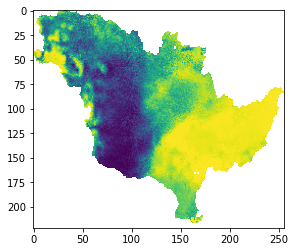

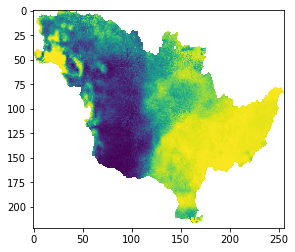

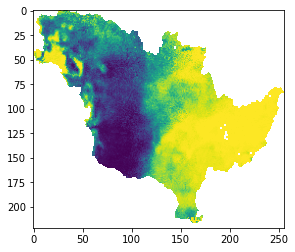

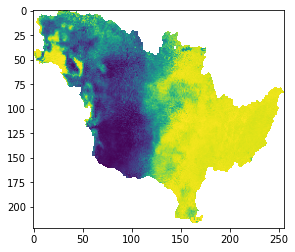

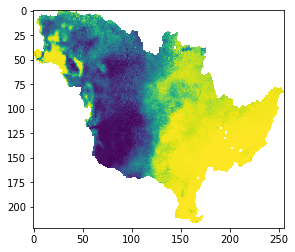

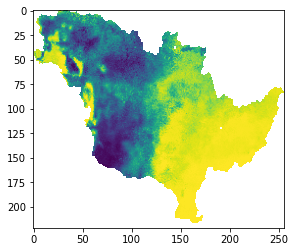

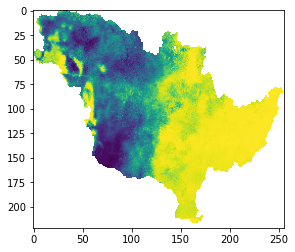

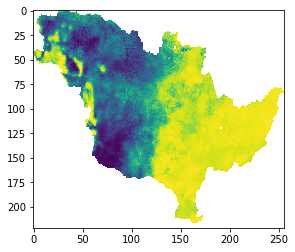

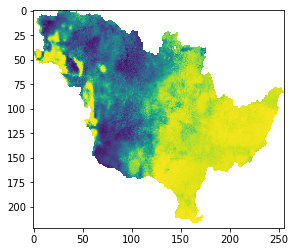

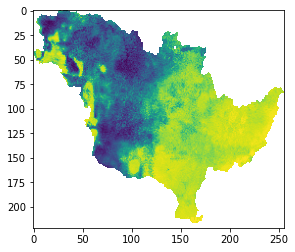

In [4]:
for x in range(10):
    plt.figure()
    plt.imshow(np.where(M[x].numpy()<0,np.nan,M[x].numpy())[0])

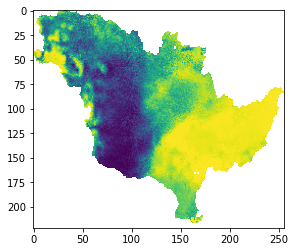

In [49]:
plt.imshow(np.where(y<0,np.nan,y))

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from matplotlib import pyplot as plt
import os
import numpy as np
from math import log10
from torch.autograd import Variable
from random import choice
from torch.utils.data import random_split
from sklearn.metrics import mean_squared_error
# import pytorch_ssim
# import arrow
from torchinfo import summary

torch.cuda.empty_cache()
torch.cuda.current_device()
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

class LARSONet(nn.Module):
    def __init__(self):
        super(LARSONet, self).__init__()
#         # in layer
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
#         # hidden layers
#         hidden_layers = []
#         for i in range(2):
#             hidden_layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
#             hidden_layers.append(nn.BatchNorm2d(64))
#             hidden_layers.append(nn.ReLU(inplace=True))
#         self.mid_layer = nn.Sequential(*hidden_layers)
#         # out layer
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=1, bias=False) #anything below this is for shrinking 
        self.linear1 = nn.Linear(222*256,100)
        self.linear2 = nn.Linear(100,50)
        self.linear3 = nn.Linear(50,20)
        self.linear4 = nn.Linear(20,10)
        self.linear5 = nn.Linear(10,1)

    def forward(self, x):
#         out1 = self.relu(self.conv1(x))
#         out = self.mid_layer(out1)
#         o = self.conv3(out+out1)
#         print('output from conv layer', o.shape)
        o = self.relu(self.linear1(x.view(x.size(0), -1)))
        o = self.relu(self.linear2(o))
        o = self.relu(self.linear3(o))
        o = self.relu(self.linear4(o))
        o = self.linear5(o)
        return o
    
class setter(Dataset):
    def __init__(self,x,y):
        self.x = torch.load(x)[:100,:,:,:].reshape(100,222,256)
        self.y = torch.load(y)[:100,:,:,:].reshape(100,1)

        print('shape of x',self.x.shape)
        print('shape of y',self.y.shape)
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx]
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx]
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]
    

# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data,0.0,0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data,1.0,0.02)
#         nn.init.constant_(m.bias.data,0)    
        
dset = setter('imz_nonans.pt','streamz.pt')
cube_size = 80
print(len(dset))
# print(dset[0])

batch_size=2

train_dset_size = int(0.80*len(dset)); print(train_dset_size)
valid_dset_size = int(0.5*(len(dset) - train_dset_size)); print(valid_dset_size)
test_dset_size = int(0.5*(len(dset) - train_dset_size)); print(test_dset_size)

train_dset, valid_dset, test_dset = random_split(dset,[train_dset_size,valid_dset_size,test_dset_size])

train_dataloader = DataLoader(dataset=train_dset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(dataset=valid_dset, batch_size=batch_size, shuffle=True, num_workers=0)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LARSONet().to("cpu")

print(summary(model,input_size=(batch_size,1,222,256)))

# model.apply(weights_init)
criterion = nn.MSELoss(reduction="mean")
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

print('training started at {}'.format(datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')))
t_loss = []
v_loss = []
e_time = []
t0 = time.time()
for i in range(epochs):
    t_e_loss = 0
    v_e_loss = 0
    t00 = time.time()
    model.train()
    for idx,(x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted = model(x)
        loss = criterion(predicted,y)
        loss.backward()
        optimizer.step()
        t_e_loss += loss.item()
    for xx,yy in valid_dataloader:
        v_pred = model(xx)
        loss2 = criterion(v_pred,yy)
        v_e_loss += loss2.item()
    t_loss.append(t_e_loss/len(train_dataloader))
    v_loss.append(v_e_loss/len(valid_dataloader))
    t11 = time.time()
    e_time.append(t11-t00)
t1 = time.time()
print('training time {} minutes'.format(np.format_float_positional((t1-t0)/60,precision=5)))

fig = plt.figure()
fig.add_subplot(211)
plt.title('mean squared error between predicted target and actual target vs. epoch\n1 hidden layer, 10 neurons, 50,000 samples\n 85/15 split, 1000 epochs, 100 batchsize, 1e-4 lr',fontsize=9)
plt.plot(t_loss)
plt.plot(v_loss)
plt.legend(['t','v'])
plt.ylabel('mse')
fig.add_subplot(212)
plt.title('time',fontsize=9)
plt.tight_layout()
plt.plot(e_time,color='red')
# plt.plot(np.cumsum(e_time),color='green')
plt.legend(['/epoch (sec)','cum (min)'])


1
NVIDIA GeForce RTX 2080 Ti
shape of x torch.Size([100, 222, 256])
shape of y torch.Size([100, 1])
100
80
10
10


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [63]:
class setter(Dataset):
    def __init__(self,x,y):
        self.x = torch.load(x)[:100,:,:,:].reshape(100,-1)
        self.y = torch.load(y)[:100,:,0,0].reshape(100,1)

        print('shape of x',self.x.shape)
        print('shape of y',self.y.shape)
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]

class MLP(torch.nn.Module):
    def __init__(self,cube_size):
        super(MLP,self).__init__()
        self.sigmoid = torch.nn.Sigmoid()
        self.fci = torch.nn.Linear(cube_size,1000)
        self.fco = torch.nn.Linear(1000,1)
        self.relu = torch.nn.ReLU()
#         self.dropout = torch.nn.Dropout(0.5)

    def forward(self,x):
        x = self.sigmoid(self.fci(x.view(x.size(0), -1)))
        x = self.fco(x)
        return x

    
# nn_ds_size = 1000
dset = setter('imz_nonans.pt','streamz.pt')
cube_height = 222
cube_width = 256
cube_size = cube_height * cube_width
epochs=50
batch_size=2
train_dset_size = int(0.85*len(dset))
valid_dset_size = int(len(dset) - train_dset_size)
train_dset, valid_dset = random_split(dset,[train_dset_size,valid_dset_size])
train_dataloader = DataLoader(dataset=train_dset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(dataset=valid_dset, batch_size=batch_size, shuffle=False)
model = net()
model.cuda()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
criterion = torch.nn.MSELoss(reduction='mean')
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=150,verbose=False)


print('training started at {}'.format(datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')))
t_loss = []
v_loss = []
e_time = []
t0 = time.time()
for i in range(epochs):
    t_e_loss = 0
    v_e_loss = 0
    t00 = time.time()
    model.train()
    for idx,(x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted = model(x)
        loss = criterion(predicted,y)
        loss.backward()
        optimizer.step()
        t_e_loss += loss.item()
    for xx,yy in valid_dataloader:
        v_pred = model(xx)
        loss2 = criterion(v_pred,yy)
        v_e_loss += loss2.item()
    t_loss.append(t_e_loss/len(train_dataloader))
    v_loss.append(v_e_loss/len(valid_dataloader))
    t11 = time.time()
    e_time.append(t11-t00)
t1 = time.time()
print('training time {} minutes'.format(np.format_float_positional((t1-t0)/60,precision=5)))

fig = plt.figure()
fig.add_subplot(211)
plt.title('mean squared error between predicted target and actual target vs. epoch\n1 hidden layer, 10 neurons, 50,000 samples\n 85/15 split, 1000 epochs, 100 batchsize, 1e-4 lr',fontsize=9)
plt.plot(t_loss)
plt.plot(v_loss)
plt.legend(['t','v'])
plt.ylabel('mse')
fig.add_subplot(212)
plt.title('time',fontsize=9)
plt.tight_layout()
plt.plot(e_time,color='red')
# plt.plot(np.cumsum(e_time),color='green')
plt.legend(['/epoch (sec)','cum (min)'])

shape of x torch.Size([100, 56832])
shape of y torch.Size([100, 1])


TypeError: forward() missing 1 required positional argument: 'input'

In [55]:
A = torch.load('streamz.pt')
A.shape

torch.Size([841, 1, 1, 1])

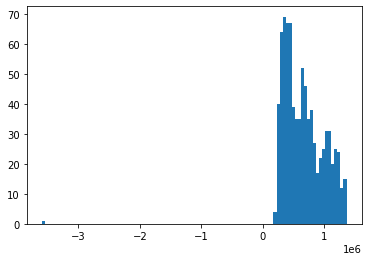

In [59]:
plt.hist(A.numpy().reshape(-1),bins=100);